# Análise sobre mortes decorrentes de complicações na Aids no ano de 2016

### Dados coletados em: DATASUS  Tecnologia da Informação a Serviço do SUS
#### Fonte: http://tabnet.datasus.gov.br

Bibliotecas importadas:

In [16]:
%matplotlib inline

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geopandas import GeoDataFrame
from shapely.geometry import Point
import pysal

### CID's 10 utilizados:

B20 Doença pelo vírus da imunodeficiência humana [HIV], resultando em doenças infecciosas e parasitárias.

B21 Doença pelo vírus da imunodeficiência humana [HIV], resultando em neoplasias malignas.

B22 Doença pelo vírus da imunodeficiência humana [HIV] resultando em outras doenças especificadas.

B23 Doença pelo vírus da imunodeficiência humana [HIV] resultando em outras doenças.

B24 Doença pelo vírus da imunodeficiência humana [HIV] não especificada.

### Os dados foram adquiridos no formato csv, na decodificação ANSI, aonde foram descartadas as linhas que não continham dados relevantes.

In [17]:
df= pd.read_csv('./dados/dados_aids_2016.csv', sep=';' , header=4, encoding='ANSI')
df = df[:316]
listaMunicipio = []

### Um looping foi criado para pegar todos os itens na coluna 'Município' e separar o geocodigo do nome do município, pois estavam na mesma coluna. Ex.: '31321 São Caetano'.

#### Após a separação e criação de uma lista somente com o nome do município, foi adicionada no dataframe.

In [18]:
for item in df['Município']:
    listaMunicipio.append(item[7:]) 
df['municipio'] = listaMunicipio

#### Removendo a coluna 'Município'

In [19]:
df = df.drop('Município',1)

#### Mudando os nomes das colunas do df para 'obitos' e 'municipio'

In [20]:
colunas = ('obitos municipio').split()
df.columns = colunas

#### A seguir foram geradas estatísticas descritivas que resumem a tendência central, a dispersão e a forma da distribuição de um conjunto de dados, excluindo valores NaN:

In [21]:
df.describe()

,obitos
count,316.000000
mean,7.984177
std,39.704261
min,1.000000
25%,1.000000
50%,2.000000
75%,6.000000
max,692.000000


#### A função a seguir, deixa os nomes dos municípios em letra maíuscula para comparação entre o dataframe e o shapefile

In [22]:
df.municipio = df.municipio.str.upper()

#### Total de mortes em decorrencia da Aids no ano de 2016

In [23]:
df['obitos'].sum()

2523.0

#### As 10 cidades com mais óbitos em decorrencia da Aids

In [24]:
df.sort_values(by=['obitos'],ascending=False).head(10)

,obitos,municipio
277,692.0,SÃO PAULO
48,69.0,CAMPINAS
96,54.0,GUARULHOS
265,46.0,SANTOS
241,41.0,RIBEIRÃO PRETO
281,40.0,SÃO VICENTE
187,40.0,OSASCO
263,39.0,SANTO ANDRÉ
287,38.0,SOROCABA
95,35.0,GUARUJÁ


#### Importação do shapefile dos municípios do estado de São Paulo
##### Foram alteradas as colunas do shpdf para 'nome', 'geocod', 'geometry'
##### Definida a coluna 'geocod' como índice 

In [25]:
shpdf = gpd.read_file('./dados/shapefile/municipios.shp')
colunas = ('nome','geocod','geometry')
shpdf.columns = colunas
shpdf = shpdf.set_index('geocod')

#### Junção do dataframe 'df' com o geodataframe 'shpdf', unindo-as pelas colunas 'municipio' e 'nome'

In [26]:
merged = df.merge(shpdf,left_on='municipio',right_on='nome',how='outer')
merged = merged.drop('nome',1)
merged = merged.dropna()

In [27]:
merged.count()

obitos       316
municipio    316
geometry     316
dtype: int64

#### O gráfico a seguir, evidencia o pico causado pelo grande número de óbitos no município de São Paulo - SP: 

Text(0, 0.5, 'Óbitos')

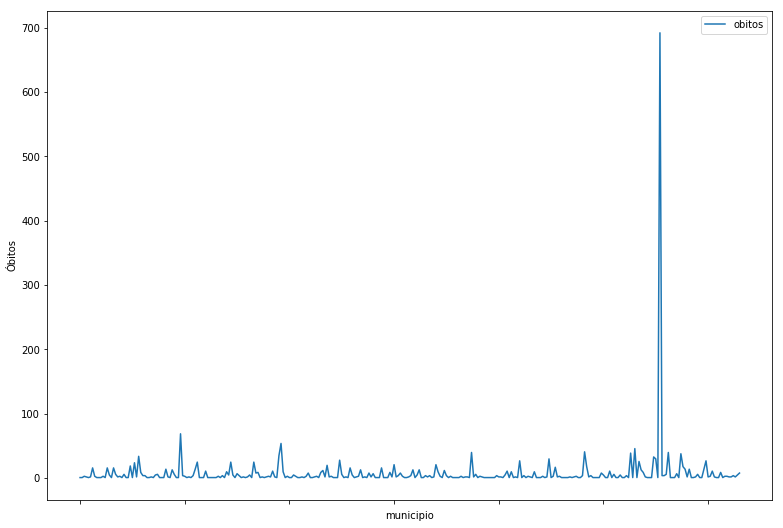

In [28]:
merged.plot(figsize=(13,9),x='municipio')
plt.ylabel('Óbitos')

#### Para gerar o mapa com os dados do dataframe, foi necessário tranformar o dataframe em geodataframe, informando o Sistema de coordenadas Sirgas 2000 (4674) e a coluna que possui a geometria.

Text(0.5, 1.0, 'Mortes decorrentes de complicações da Aids - 2016')

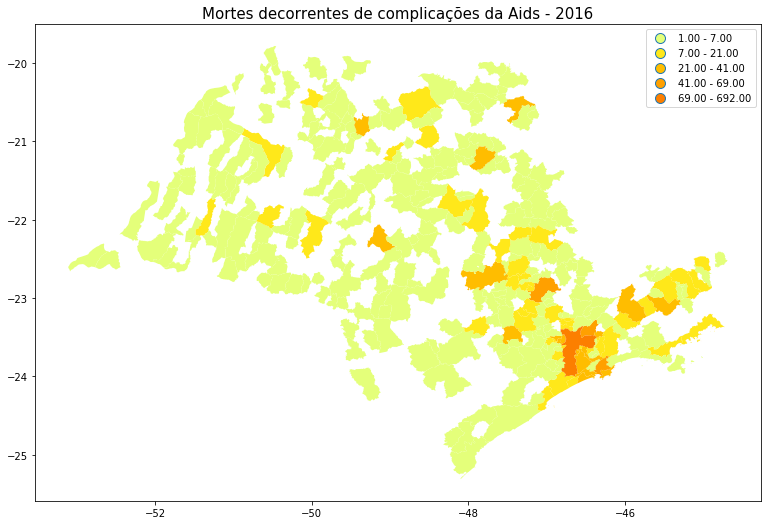

In [29]:
mergedgdf = GeoDataFrame(merged, crs=4674, geometry='geometry')
mergedgdf.plot(column = 'obitos', figsize=(13,9),cmap='Wistia', scheme='fisher_jenks', legend=True)
plt.title('Mortes decorrentes de complicações da Aids - 2016',fontsize=15)
